In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from terminus import termpicks_trace, termpicks_centerline, termpicks_interpolation
import math
import numpy as np
import pandas as pd
from scipy import interpolate
plt.rcParams.update({'font.size': 30})
from datetime import datetime

In [3]:
termpicks = gpd.read_file('Terminus/TermPicks+Calfin_v2/TermPicks+CALFIN_V2.shp')

In [47]:
for num in [1]:   
    glacier =termpicks_trace(termpicks,num).data
    glacier = glacier.sort_values(by=['DecDate'])
    glacier = glacier[glacier['DecDate']>1985]
    geoms = glacier.geometry.to_list()

    sinuo = []
    check = []
    for line in geoms:
        downval = line.boundary[0].distance(line.boundary[1])
        channel = line.length

        s = channel/downval

        if s > 2:
            sinuo.append(np.nan)
        else:
            sinuo.append(channel/downval)

    glacier['sinu'] = sinuo
    
    dates = glacier['Date'].to_list()
    datelist=[]
    for i in dates:
        year = i[0:4]
        month = i[5:7]
        day = i[8:10]
        if month == '00':
            month = '07'
            day = '02'
        datelist.append(year+'-'+month+'-'+day)

    dts = [datetime.strptime(date, '%Y-%m-%d').date() for date in datelist]
    
    glacier['date'] = datelist
    glacier['DT'] = pd.to_datetime(glacier['date'])
    DO = glacier['DT'].map(datetime.toordinal).to_list()
    

    #Smoothing SINU
    X = DO
    Y = sinuo
    x = X
    y = Y
    f = interpolate.interp1d(x, y)
    xnew = list(np.arange(X[0], X[-1], 15))
    ynew = list(f(xnew))   # use interpolation function returned by `interp1d
    interp = pd.DataFrame(ynew, index = xnew, columns=['interp'])
    rolling = interp.interp.rolling(window=24,min_periods=1)
    rolling_mean = rolling.mean()
    roll_df = rolling_mean.to_frame(name='interp')
    roll_df  = roll_df.shift(periods=-12)
    #roll_df['DT']=roll_df.index.map(datetime.fromordinal)
    roll_df['orig_interp'] = interp
    roll_df['DT']=roll_df.index.map(datetime.fromordinal)
    sinu_df = roll_df
    
    
    retreat_df = pd.read_csv('Retreat/1interp.csv')
    retreat_df['DT'] = pd.to_datetime(retreat['DT'])
    
    #HAB
    hab_df_r=gpd.read_file('HAB_Sampled/1.shp')
    hab_df_r['DT'] = pd.to_datetime(hab_df_r['Date'])
    #smoothing hab
    X = hab_df_r['DT'].map(datetime.toordinal).to_list()
    Y = hab_df_r['mean']
    x = X
    y = Y
    f = interpolate.interp1d(x, y)
    xnew = list(np.arange(X[0], X[-1], 15))
    ynew = list(f(xnew))   # use interpolation function returned by `interp1d
    interp = pd.DataFrame(ynew, index = xnew, columns=['interp'])
    rolling = interp.interp.rolling(window=24,min_periods=1)
    rolling_mean = rolling.mean()
    roll_df = rolling_mean.to_frame(name='interp')
    roll_df  = roll_df.shift(periods=-12)
    #roll_df['DT']=roll_df.index.map(datetime.fromordinal)
    roll_df['orig_interp'] = interp
    roll_df['DT']=roll_df.index.map(datetime.fromordinal)
    hab_df = roll_df







C:\Users\sofyg\Anaconda3\envs\geo_env\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\sofyg\Anaconda3\envs\geo_env\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Text(0.5, 0.98, 'Glacier 1')

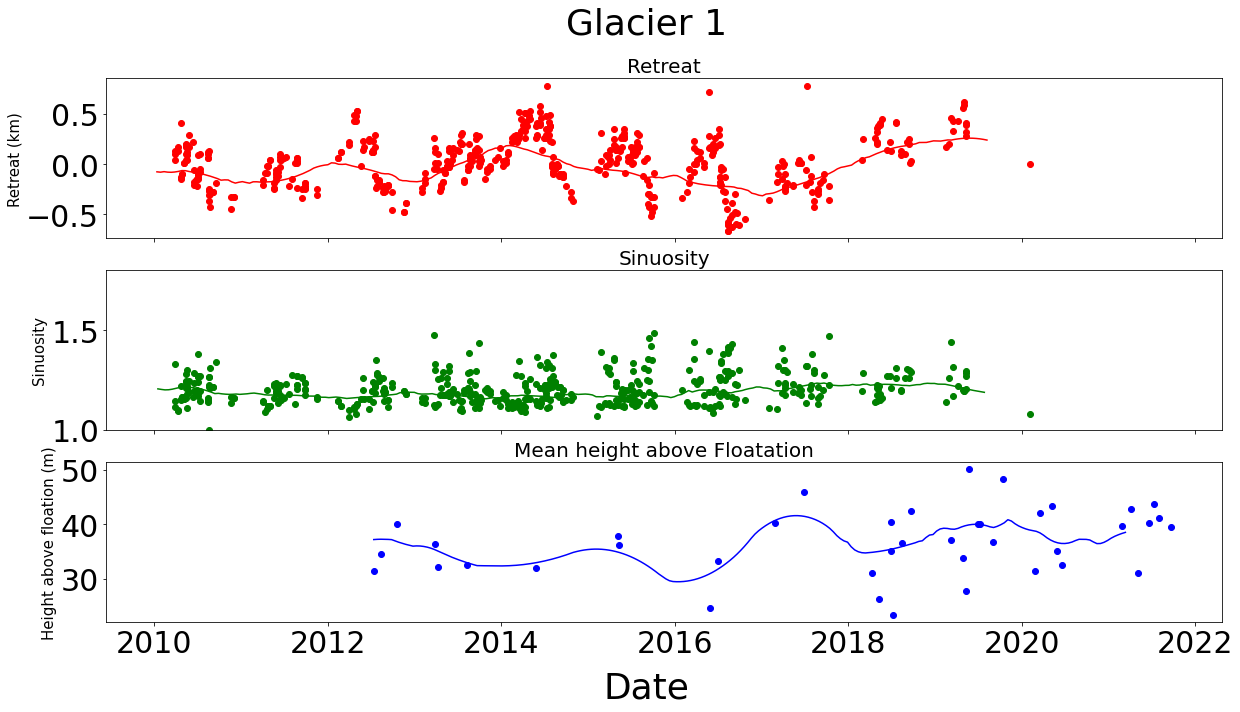

In [81]:

#plt.scatter(glacier.DT,glacier.sinu,color = c,alpha = 0.3)
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,10), sharex=True)
# Defining custom 'xlim' and 'ylim' values.

#Retreat
retreat_df =retreat_df[retreat_df['DT']>'2010']
ax1.plot(retreat_df.DT,retreat_df.interp/1000,color = 'red')

retreat_raw = pd.read_csv('Retreat/1.csv')
retreat_raw['DT'] = pd.to_datetime(retreat_raw['date'])
retreat_raw =retreat_raw[retreat_raw['DT']>'2010']
ax1.scatter(retreat_raw.DT,retreat_raw.retreat/1000,color = 'red')

#Sinuosity
sinu_df =sinu_df[sinu_df['DT']>'2010']
ax2.plot(sinu_df['DT'],sinu_df.interp,color = 'Green')
ax2.set_ylim([1, 1.8])

glacier =glacier[glacier['DT']>'2010']
ax2.scatter(glacier['DT'],glacier['sinu'],color = 'Green')
 

#Float
ax3.plot(hab_df['DT'],hab_df.interp,color = 'Blue')
ax3.scatter(hab_df_r['DT'],hab_df_r['mean'],color = 'Blue')


ax1.set_title('Retreat',fontsize = 20)
ax2.set_title('Sinuosity',fontsize = 20)
ax3.set_title('Mean height above Floatation',fontsize = 20)

ax1.set_ylabel('Retreat (km)',fontsize = 15)
ax2.set_ylabel('Sinuosity',fontsize = 15)
ax3.set_ylabel('Height above floation (m)',fontsize = 15)

fig.supxlabel('Date')
plt.suptitle('Glacier 1')
